In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.filters import convolve as filter2

C:\Users\Mahmoud\AppData\Local\Temp\ipykernel_10700\3262453794.py:4: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve as filter2


# Sparse Optical Flow

In [20]:
#compute magnitude in each 8 pixels. return magnitude average
def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg

In [21]:
def draw_quiver(u,v,first_frame):
    scale = 3
    ax = plt.figure(figsize=(20, 20)).gca()
    ax.imshow(first_frame, cmap = 'gray')

    mag_avg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > mag_avg:
                ax.arrow(j,i, dx, dy, color = 'red')

    plt.draw()
    plt.show()

In [22]:
#compute derivatives of the image intensity values along the x, y, time
def get_derivatives(first_frame, second_frame):
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(first_frame,x_kernel) + filter2(second_frame,x_kernel)
    fy = filter2(first_frame, y_kernel) + filter2(second_frame, y_kernel)
    ft = filter2(first_frame, -t_kernel) + filter2(second_frame, t_kernel)

    return [fx,fy, ft]

In [23]:
#input: first_frame,seconf_frame, smoothing parameter, tolerance
#output: images variations (flow vectors u, v)
#calculates u,v vectors and draw quiver
def compute_horn_schunck (frame1, frame2, alpha, delta):

    #removing noise
    first_frame  = cv2.GaussianBlur(frame1, (5, 5), 0)
    second_frame = cv2.GaussianBlur(frame2, (5, 5), 0)

    # set up initial values
    u = np.zeros((first_frame.shape[0], first_frame.shape[1]))
    v = np.zeros((first_frame.shape[0], first_frame.shape[1]))
    
    fx, fy, ft = get_derivatives(first_frame, second_frame)
    # laplacian mask
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        #converges check (at most 300 iterations)
        if  diff < delta or iter_counter > 300:
            break

    print(iter_counter)
    draw_quiver(u, v, first_frame)
    return [u, v]

(360, 640)
167


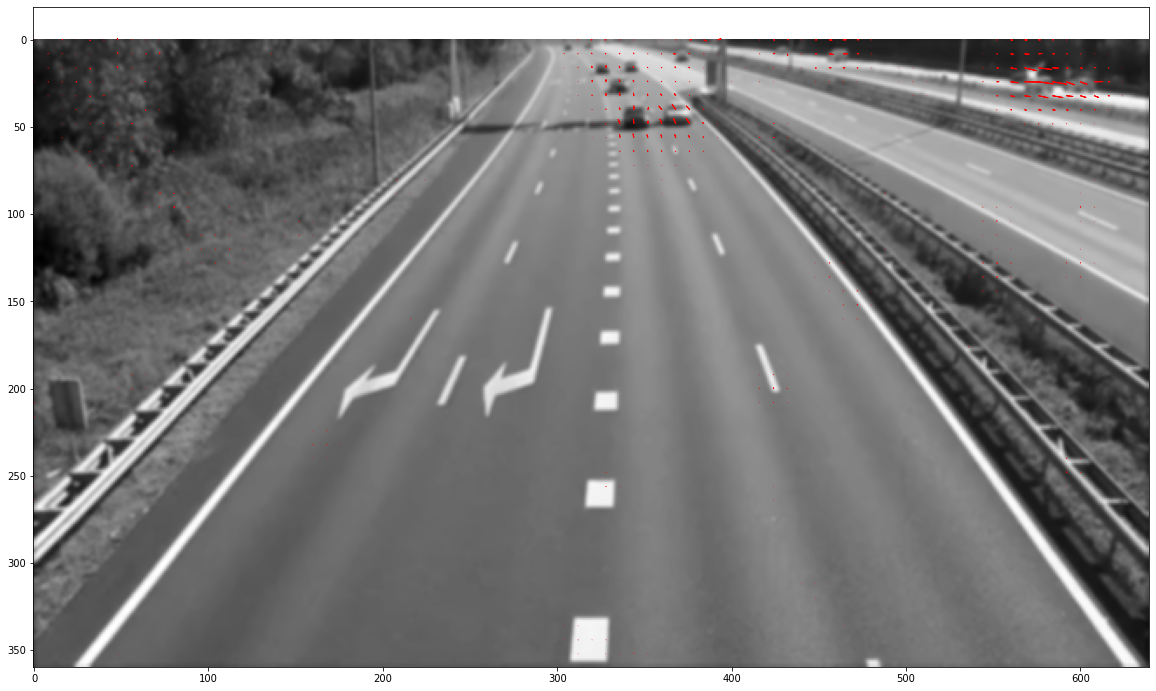

In [24]:
cap = cv2.VideoCapture('./traffic_-_27260 (360p).mp4')

# Read the first frame
ret, frame1 = cap.read()
ret,frame2=cap.read()


first_frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY).astype(float)
second_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY).astype(float)
print(first_frame.shape)
u,v = compute_horn_schunck(first_frame, second_frame, alpha = 15, delta = 10**-1)